# 1. Дизайн эксперимента


Прежде чем приступить к основному тестированию, необходимо определиться с гипотезами. Это позволит убедиться в том, что интерпритация полученных результатов является правильной и мы не ошибемся.
Посколько мы заранее не имеем представления о том, будет ли новый дизайн сайта работать лучше или хуже чем текущий вариант сайта, мы выбираем двусторонний статистический тест [Two-Tailed Test](https://towardsdatascience.com/hypothesis-testing-2-tailed-test-42f0d5ef1071)


H0 : p  = p0
H  : p != p0

где p и p0 означают коэффициенты конверсии между новым и старым вариантами соответственно. Так же необходимо выбрать уровень доверия (confidence level). В нашем случае мы решили что это будет 95%.
Имея уровень доверия в 95% необходимо рассчитать показатель альфа, который будет равен (1 - 0.95) для нашего теста = 0.05.

-----
Альфа — это очень важная в мире статистики величина, связанная с рядом других ключевых понятий, влияющих на сплит-тестирование и определяющая, насколько точными будут результаты тестов.
Альфа математически взаимосвязана с такими показателями как:
* p-значение (p-value). Это величина, используемая при тестировании статистических гипотез. Фактически это вероятность ошибки при отклонении нулевой гипотезы;
* значимость (Significant), то есть взаимная связь между двумя группами наблюдений, позволяющая выявить различие между ними. Пожалуй, самый сложный для понимания термин, поскольку само слово может ввести в заблуждение;
* уровень доверия к результатам (Confidence Level).
При этом все эти три показателя, а также сам коэффициент Альфа, часто путают между собой. Чтобы внести ясность, стоит разобраться, как эти понятия соотносятся друг с другом.



https://cxl.com/blog/statistical-power/

----

Простым языком, альфа - это тот порог, который мы устанавливаем. Интерпритация альфы чаще всего следующая: "Если вероятность наблюдения экстремальных значений (p-значение) меньше чем альфа, то тогда мы с легкостью можем отклонить Нулевую гипотезу."
Так как наш уровень альфы 0.05 (обозначающий 5% -ую вероятность), то наш доверительный интервал (1-0.05) = 0.95 или 95%

Итого вне зависимости от того какой уровень конверсии мы будем наблюдать для нашего нового дизайна, мы хотим быть уверены на 95% что он статистически отличается от того уровня конверсии, который принадлежит старой версии прежде чем мы решим отклонить нулевую гипотезу H0

----

Для проведения A/B тестирования нам необходимо 2 группы испытемых:
1. Контрольная (Control) группа - та группа пользователей, которым будет показываться старая версия сайта.
2. Эксперементальная (Treatment) группа - та группа пользователей, которым будет показываться новая версия сайта.


Почему у нас 2 группы не смотря на то, что мы уже знаем наш средний показатель конверсии?
Причина заключается в том, что мы хотим иметь возможность контроллировать и другие переменные для нашего анализа, которые также могут повлиять на результаты (например сезонность, возрастная группа, локация и так далее).
Имея контрольную группу мы можем напрямую сравнивать результаты двух выборок, потому что единственное изменение между групами - дизайн сайта. И все различия мы можем отнести к тому, что мы поменяли дизайн сайта.


Нашей целевой переменной (Dependant Variable) будет выступать - уровень конверсии (conversion_rate). Целевая переменная представленна бинарно:
0 - пользователь не купил ничего в течение своей сессии на сайте
1 - пользователь купил продукт в течение своей сессии на сайте



Сессия - термин, используемый для того, чтобы обозначить время проведенное пользователем на сайте (веб-приложении, мобильном приложении)


In [1]:
# Установим модули - просто уберите комментарии и запустите ячейку с кодом, комментарий обозначется символом #
#! pip3 install numpy pandas scipy statsmodels matplotlib seaborn

You should consider upgrading via the 'C:\Users\busta\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [20]:
# Импортируем библиотеки
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import pathlib
from pathlib import Path
path = Path(pathlib.Path.home(), 'PycharmProjects', 'homework2',  'data', 'ab_test_ensembles.csv')

# Настройки отображения графиков
%matplotlib inline
# Стили графиков -> обращайтесь в документацию по seaborn https://seaborn.pydata.org/generated/seaborn.set_style.html
plt.style.use('seaborn-whitegrid')
font = {'family' : ' DejaVu Sans',
        'weight' : 'bold',
        'size'   : 14}
mpl.rc('font', **font)

# Определение размера контрольной и испытуемой выборок.

Анализ мощности выборки зависит от нескольких факторов:
1. Мощность теста (1 - бетта) - представляет с собой вероятность найти статистические различия между групами в тесте если действительно существует разница между групами. Обычно кастомным показателем в большинстве тестов выбирают 0.8
2. Альфа фактов (альфа) - критическое значение, которое мы установили выше 0.05
3. Эффект/Размер эффекта/Размах Эффекта - то насколько сильна разница между двумя целевыми показателям (нам необходимо 2% между двумя групами).

К нашему счастью, Python комьюнити предоставило нам модуль statsmodels который сделает всю грязную работу за нас:

In [21]:
# Считаем размер эффекта -> https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportion_effectsize.html
effect_size = sms.proportion_effectsize(0.13, 0.15)
# Cчитаем необходимый размер выборки -> https://www.statsmodels.org/dev/generated/statsmodels.stats.power.NormalIndPower.html?highlight=normalindpower
# https://www.statsmodels.org/dev/generated/statsmodels.stats.power.NormalIndPower.solve_power.html#statsmodels.stats.power.NormalIndPower.solve_power
required_n = sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1) # Calculating sample size needed
# Округляем до ближайшего целого
required_n = ceil(required_n)
print("Для каждой группы нам необходимо не меньше ",required_n, " наблюдений")

Для каждой группы нам необходимо не меньше  4720  наблюдений


# 2. Сбор данных и их подготовка

Таким образом мы получили ответ на вопрос, сколько людей нам необходимо для проведения эксмеримента. На данном этапе вы топаете ножками к вашей Back-End команде либо Data Engineering команде и объясняете суть эксперимента, устанавливайте условия эксперимента, оцениваете его сроки (зависит от потока траффика на ваш сайт/приложение и считаете за сколько времени вы наберете необходимое количество пользователей).

Мы же будем использовать симуляционный датасет, чтобы смоделировать ситуацию.

In [25]:
df = pd.read_csv(path).copy()
df.head(10)

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user
5,426f77eb-8739-43b6-999c-aecd14d9f346,2022-05-10 15:20:49.083499,control,standard,0,United Kingdom,42-49,registered_user
6,aa9d93c5-a18f-444a-a522-7e7145835362,2022-05-19 03:26:46.940749,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,registered_user
7,de214e30-9b8d-44cf-87b1-16917f3e1c89,2022-05-17 01:48:29.539573,control,standard,0,United Kingdom,18-25,registered_user
8,070f398e-e6bf-43e7-88bb-37eff2cb9212,2022-05-04 17:58:08.979471,treatment,svm_ensemble_v_1_22,1,United Kingdom,18-25,new_user
9,9cff0b7e-d42b-4508-9fbe-a4e74f7f29c5,2022-05-15 18:11:06.610965,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,new_user


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


In [26]:
# Убедимся, что контрольная группа и испытуемая видят старую страницу и новую -> https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html
pd.crosstab(df['group'], df['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,1928
treatment,1965,145311


Прежде чем продолжим, давайте проверим данные на предмет дубликатов пользователей из нашей выборки.

In [27]:
sessions = df['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(f"У нас имеются {duplicate_users} пользователей, которые не уникальны в нашей выборке.")

У нас имеются 0 пользователей, которые не уникальны в нашей выборке.


In [28]:
users_to_drop = sessions[sessions > 1].index
# Проверяем вхождения, знак ~ логическо нет
df = df[~df['user_id'].isin(users_to_drop)]
print(f"Количество пользователей без дубликтов {df.shape[0]}")

Количество пользователей без дубликтов 294478


В предствленной выборке нет дубликатов.

In [29]:
control_sample = df[df['group'] == 'control'].sample(n = required_n, random_state=42)
treatment_sample = df[df['group'] == 'treatment'].sample(n = required_n, random_state=42)

# Сформируем общую случайную выборку
ab_df = pd.concat([control_sample, treatment_sample], axis=0)
ab_df.reset_index(drop=True, inplace=True)
ab_df.head()

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,bcf8452b-3056-4d45-994f-5f286fd9869a,2022-05-18 04:44:18.590293,control,standard,0,United Kingdom,42-49,new_user
1,3c827a98-0868-4ce5-ac31-8195e243af37,2022-05-14 05:22:43.771772,control,standard,0,United Kingdom,50-57,new_user
2,71c72bb9-13d9-4755-b398-b2c5d8b1c4d6,2022-05-23 08:52:53.050325,control,standard,0,United Kingdom,34-41,new_user
3,654ee878-b0c5-4223-b9fb-995ca3d2eaf1,2022-05-07 23:27:09.109877,control,standard,0,United Kingdom,26-33,registered_user
4,1e044366-7e86-4d92-bba7-3afaa6f887f8,2022-05-20 14:26:10.133979,control,standard,0,United Kingdom,42-49,new_user


In [30]:
ab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    9440 non-null   object
 1   timestamp  9440 non-null   object
 2   group      9440 non-null   object
 3   variants   9440 non-null   object
 4   converted  9440 non-null   int64 
 5   location   9440 non-null   object
 6   age_group  9440 non-null   object
 7   user_type  9440 non-null   object
dtypes: int64(1), object(7)
memory usage: 590.1+ KB


In [15]:
ab_df.group.value_counts(normalize=True)

control      0.5
treatment    0.5
Name: group, dtype: float64

# 3. Визуализация Результатов Эксперимента

Первым делом, что необходимо сделать - рассчитать выборочные статистики, чтобы понять каково распределение данных и как выглядят наши выборки:

In [16]:
conversion_rates = ab_df.groupby('group')['converted']

# Стандартное отклонение для сформированной выборки
std_proportion = lambda x: np.std(x, ddof=0)
# Стандартная ошибка для сформированной выборки, формулу стандартной ошибки вы знаете из лекций. Забыли - погуглите.
se_proportion = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
group,,,
control,0.130791,0.337172,0.005667
treatment,0.118079,0.322702,0.005424


Как мы видим по метрикам, два эксперимента +/- по выборочным статистикам показывают себя одинаково, за исключением выборочного среднего коэффициента конверсии ~13.1% против ~11.08%

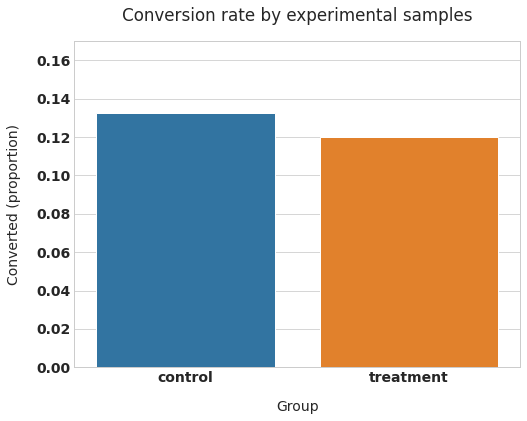

In [33]:
plt.figure(figsize=(8,6));
sns.barplot(x=ab_df['group'], y=ab_df['converted'], ci=False);
plt.ylim(0, 0.17);
plt.title('Conversion rate by experimental samples', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

Теперь главный вопрос:
- Действительно ли разница между двумя группами испытуемых является статистически значимой? И какой же вариант нам стоит оставить?

# 4. Тестирование гипотезы

Последним шагом в нашем анализе - остается построить инференциальный вывод (инференс, влияние). Так как у нас достаточно большая выборка, мы будем использовать нормальную аппроксимацию. Мы можем рассчитать p-статистику (Z-test):

In [32]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_df[ab_df['group'] == 'control']['converted']
treatment_results = ab_df[ab_df['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 1.83
p-value: 0.067
CI 95% for control group: [0.123, 0.142]
CI 95% for treatment group: [0.111, 0.129]


# 5. Интерпритация результатов

Так как наше p-значение = 0.067 близко к выбранной альфа = 0.05, то согласно статистическому выводу, мы можем отклонить нулевую гипотезу H0, что означает наш новый сайт никак статистически значимо не влияет на уровень конверсии и повышение уровня конверсии - это случайность.
Полученный результат является статистически значимым, поскольку р-значение близок к альфа

Доверительный интервал для испытуемой группы [0.11, 0.13] или 11% и 13% соответственно:
1. Он включает наш baseline
2. Он не достигает нашей цели 15%

Доверительный интервал для контрольной группы [0.12, 0.14] или 12% и 14% соответственно:
1. Он включает наш baseline
2. Он не достигает нашей цели 15%

Мы можем интерпритировать так: наиболее вероятно, что реальный уровень конверсии сайта с новым дизайном будет близок к baseline чем к 15%, который мы определили по нашей цели. Однако доверительный интервал для контрольной группы к ней ближе.
Вывод. Оставить прежний дизайн сайта.